In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)

2024-09-05 16:34:08.913422: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 16:34:08.924429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 16:34:08.936718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 16:34:08.940728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 16:34:08.950653: I tensorflow/core/platform/cpu_feature_guar

In [3]:
print(tf.__version__)

2.17.0


In [4]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1725575651.793127   75176 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725575651.850712   75176 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725575651.853630   75176 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [5]:
tf.keras.backend.clear_session()

In [6]:
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpu)

    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

### Data Paths


In [8]:
train_path = "../data/archive/seg_train/seg_train/"
test_path = "../data/archive/seg_test/seg_test/"
prediction_path = "../data/archive/seg_pred/seg_pred/"

In [9]:
import os
import glob as gb

for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path) + folder + "/*.jpg")
    print(f"For training data, found {len(files)} in folder {folder}")

For training data, found 2191 in folder buildings
For training data, found 2271 in folder forest
For training data, found 2404 in folder glacier
For training data, found 2512 in folder mountain
For training data, found 2274 in folder sea
For training data, found 2382 in folder street


In [10]:
for folder in os.listdir(test_path):
    files = gb.glob(pathname=str(test_path) + folder + "/*.jpg")
    print(f"For testing data, found {len(files)} in folder {folder}")

For testing data, found 437 in folder buildings
For testing data, found 474 in folder forest
For testing data, found 553 in folder glacier
For testing data, found 525 in folder mountain
For testing data, found 510 in folder sea
For testing data, found 501 in folder street


In [11]:
files = gb.glob(pathname=str(prediction_path) + "/*.jpg")
print(f"For training data, found {len(files)}")

For training data, found 7301


## Loading the data


In [12]:
encode = {
    "buildings": 0,
    "forest": 1,
    "glacier": 2,
    "mountain": 3,
    "sea": 4,
    "street": 5,
}

IMG_SIZE = (150, 150)
n_classes = len(encode)

In [13]:
from tqdm import tqdm
import numpy as np
import cv2


def load_data(data_path: str, img_size: tuple, encode: dict, is_test: bool = False):
    images, labels = [], []

    for folder in tqdm(os.listdir(data_path), desc="Folders"):
        label = encode[folder]
        folder_path = os.path.join(data_path, folder)

        for file in tqdm(
            os.listdir(folder_path), desc=f"Files in {folder}", leave=False
        ):
            img_path = os.path.join(folder_path, file)

            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read image: {img_path}")
                continue

            try:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
            except cv2.error as e:
                print(f"Error processing image {img_path}: {str(e)}")
                continue

            images.append(img)
            labels.append(label)

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return images, labels

In [14]:
X_train, y_train = load_data(train_path, IMG_SIZE, encode)
X_test, y_test = load_data(test_path, IMG_SIZE, encode)

Folders: 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]


In [15]:
X_train.shape, y_train.shape

((14034, 150, 150, 3), (14034,))

In [16]:
X_test.shape, y_test.shape

((3000, 150, 150, 3), (3000,))

In [17]:
import matplotlib.pyplot as plt


def display_examples(images, labels):
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    x = 1
    idx = np.random.choice(images.shape[0], 30, replace=False)

    for i in idx:
        plt.subplot(5, 6, x)
        plt.xticks([])
        plt.yticks([])

        plt.grid(False)
        plt.imshow(images[i] / 255, cmap=plt.cm.binary)
        plt.xlabel(list(encode.keys())[labels[i]])

        x += 1

    plt.show()

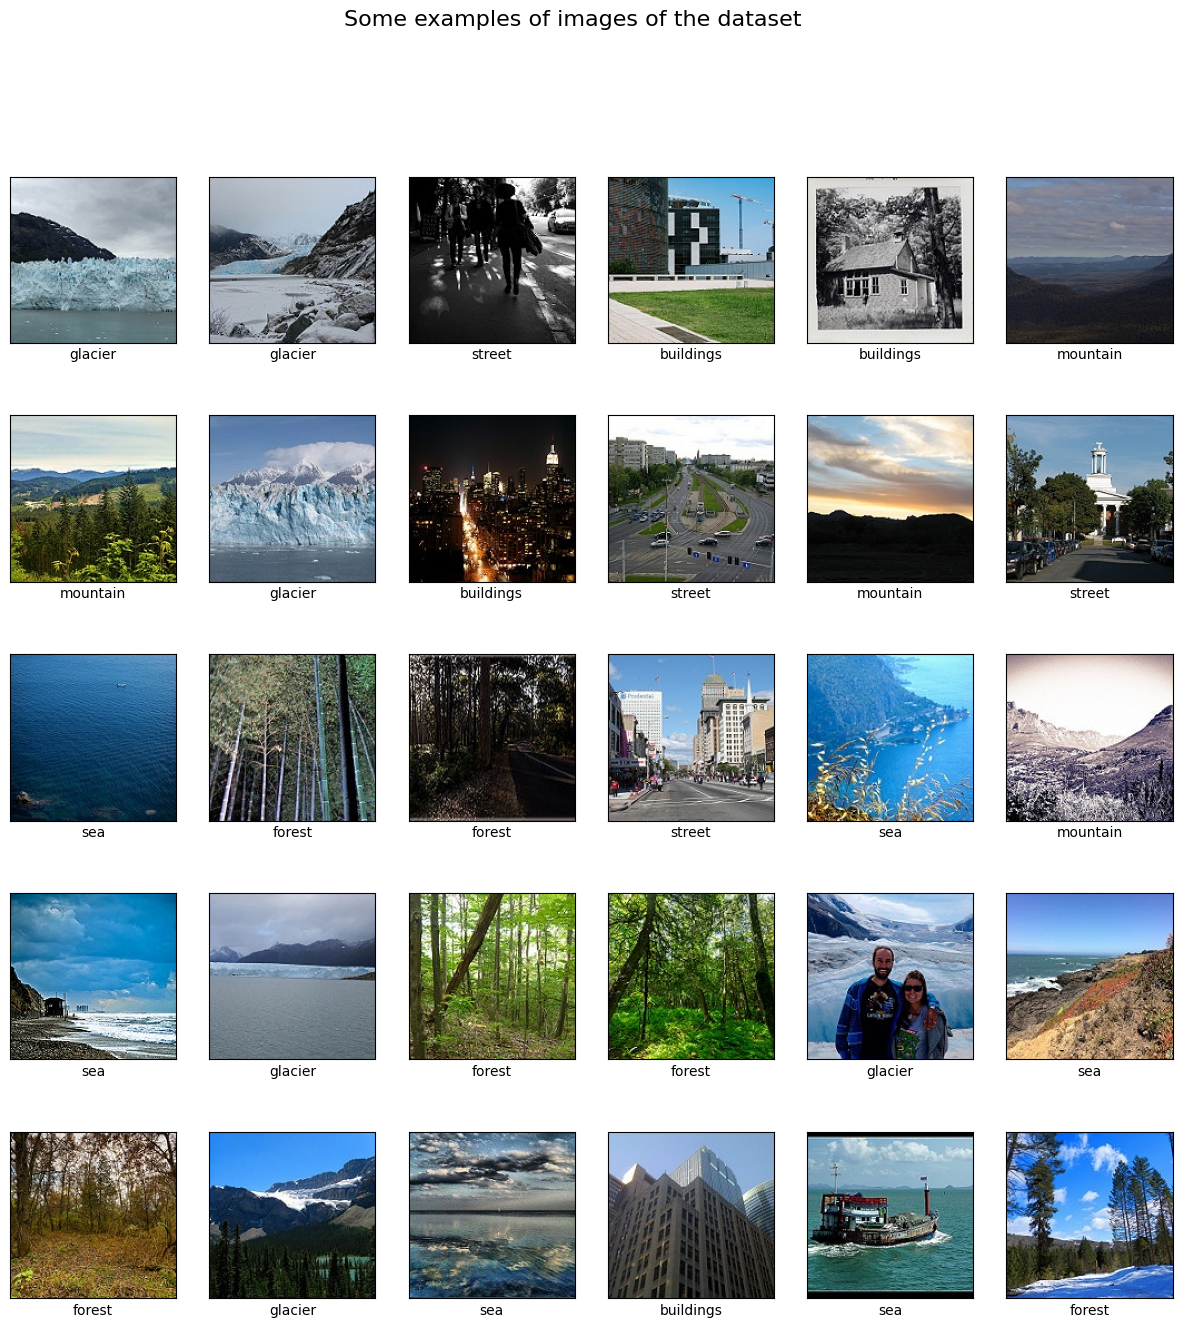

In [18]:
display_examples(X_train, y_train)

In [19]:
idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]

iddx = np.random.permutation(X_test.shape[0])
X_test = X_test[iddx]
y_test = y_test[iddx]

In [20]:
X_train /= 255
X_test /= 255

In [21]:
from tensorflow.keras.layers import LeakyReLU, Add, Input


def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = Conv2D(filters, kernel_size, stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.1)(x)

    return x


def create_model(input_shape=(150, 150, 3), n_classes=10):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)
    outputs = Dense(n_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
model = create_model(input_shape=(150, 150, 3), n_classes=n_classes)

I0000 00:00:1725575661.342714   75176 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725575661.345808   75176 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725575661.348669   75176 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725575661.491021   75176 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [23]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        896 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 150,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     36,928 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 75, 75,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 75, 75,    │          0 │ add[0][0]         │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 37,    │          0 │ leaky_re_lu_2[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_1[

 Total params: 1,403,206 (5.35 MB)

 Trainable params: 1,399,942 (5.34 MB)

 Non-trainable params: 3,264 (12.75 KB)

In [ ]:
EPOCHS = 300
BATCH_SIZE = 32

In [25]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE // 2, validation_split=0.2
)

Epoch 1/50


I0000 00:00:1725575669.569245   76129 service.cc:146] XLA service 0x772eb802ca60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725575669.569268   76129 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-09-05 16:34:29.648913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-05 16:34:30.287805: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 11/702 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.1736 - loss: 3.1817

I0000 00:00:1725575679.419859   76129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


702/702 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.5282 - loss: 2.2964 - val_accuracy: 0.7047 - val_loss: 0.9907
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7109 - loss: 1.1251 - val_accuracy: 0.7414 - val_loss: 0.7480
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7728 - loss: 0.7712 - val_accuracy: 0.7374 - val_loss: 0.8319
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7971 - loss: 0.6348 - val_accuracy: 0.7627 - val_loss: 0.6271
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8211 - loss: 0.5305 - val_accuracy: 0.7969 - val_loss: 0.6124
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8332 - loss: 0.4763 - val_accuracy: 0.6327 - val_loss: 1.0723
Epoch 7/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8463 - loss: 0.4382 - val_accuracy: 0.7588 - val_loss: 0.7004
Epoch 8/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8565 - loss: 0.4229 - val_accurac

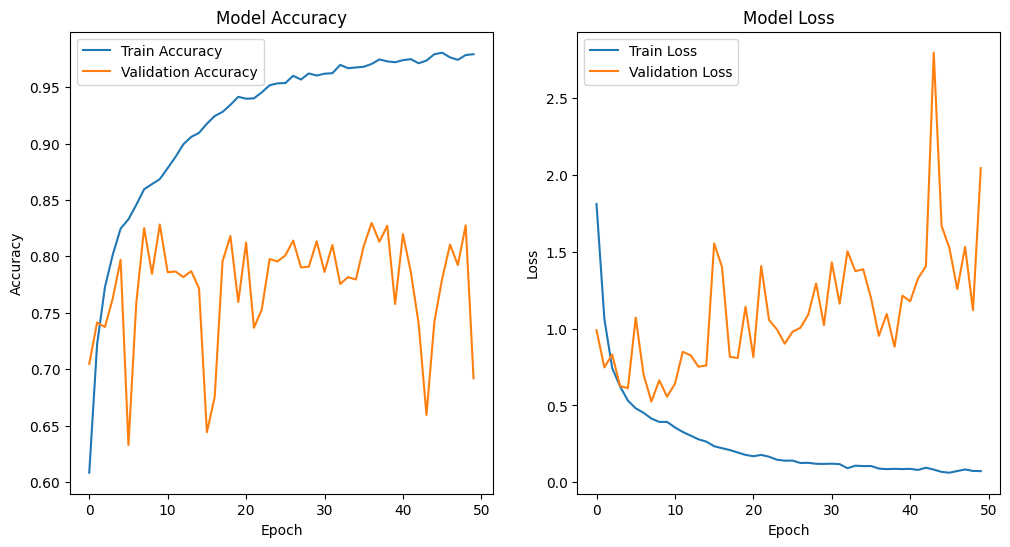

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")

# Show the plots
plt.show()

In [27]:
model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6827 - loss: 1.9600


[1.9048572778701782, 0.6946666836738586]

2024-09-05 16:44:40.312888: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


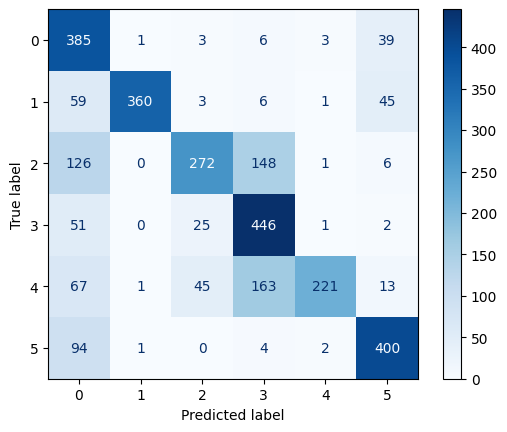

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", colorbar=True)

## Fine Tunning


In [29]:
# fine-tuning
model.trainable = True

for layer in model.layers[:-5]:
    layer.trainable = False

In [30]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [31]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS // 2,
    batch_size=BATCH_SIZE // 2,
    validation_split=0.2,
)

Epoch 1/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9566 - loss: 0.1354 - val_accuracy: 0.8354 - val_loss: 0.9308
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9781 - loss: 0.0717 - val_accuracy: 0.8361 - val_loss: 0.9414
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9804 - loss: 0.0633 - val_accuracy: 0.8422 - val_loss: 0.9597
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9792 - loss: 0.0605 - val_accuracy: 0.8404 - val_loss: 0.9520
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9839 - loss: 0.0509 - val_accuracy: 0.8375 - val_loss: 0.9469
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9834 - loss: 0.0545 - val_accuracy: 0.8347 - val_loss: 1.0055
Epoch 7/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9860 - loss: 0.0404 - val_accuracy: 0.8354 - val_loss: 1.0026
Epoch 8/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9856 - loss: 0.0424 - val_accuracy: 

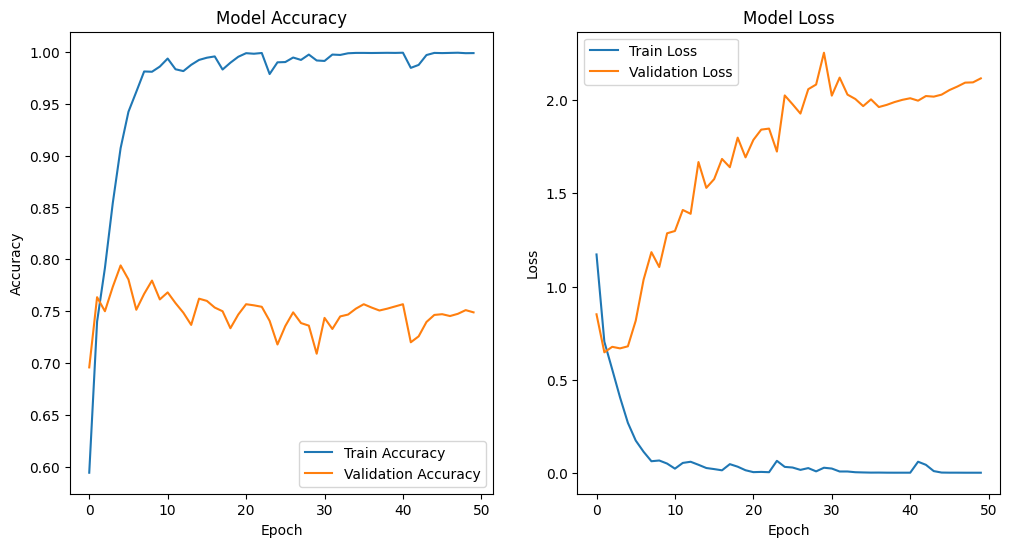

In [39]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")

# Show the plots
plt.show()

## Simple model


In [32]:
def create_simplified_model(input_shape=(150, 150, 3), n_classes=6):
    model = Sequential(
        [
            Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            Flatten(),
            Dense(64, activation="relu"),
            Dense(n_classes, activation="softmax"),
        ]
    )

    return model

In [33]:
model = create_simplified_model(input_shape=(150, 150, 3), n_classes=n_classes)

/home/carlossalguero/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,750 (18.28 MB)

 Trainable params: 4,791,750 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2
)

Epoch 1/50
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4704 - loss: 1.8351

2024-09-05 16:48:40.712872: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_221', 24 bytes spill stores, 24 bytes spill loads

2024-09-05 16:48:40.785854: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_221', 12 bytes spill stores, 12 bytes spill loads



351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4711 - loss: 1.8313

2024-09-05 16:48:44.761142: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 164 bytes spill stores, 164 bytes spill loads



351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.4714 - loss: 1.8294 - val_accuracy: 0.6958 - val_loss: 0.8512
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7260 - loss: 0.7345 - val_accuracy: 0.7634 - val_loss: 0.6471
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7861 - loss: 0.5578 - val_accuracy: 0.7499 - val_loss: 0.6767
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8533 - loss: 0.4066 - val_accuracy: 0.7734 - val_loss: 0.6683
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9050 - loss: 0.2682 - val_accuracy: 0.7941 - val_loss: 0.6794
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9517 - loss: 0.1532 - val_accuracy: 0.7805 - val_loss: 0.8169
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9650 - loss: 0.1075 - val_accuracy: 0.7513 - val_loss: 1.0365
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9807 - loss: 0.0637 - val_accuracy: 0.76

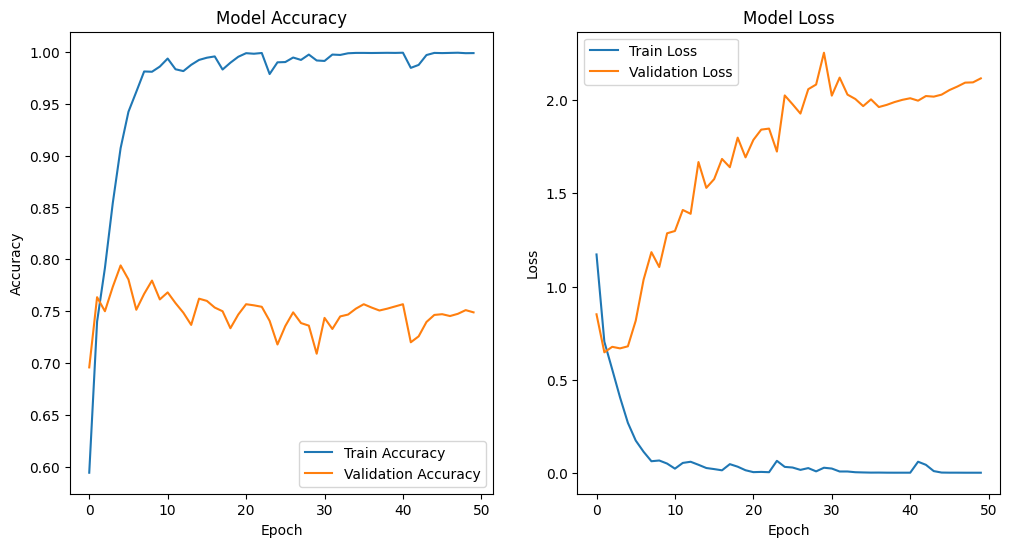

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="best")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")

# Show the plots
plt.show()

In [38]:
model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7514 - loss: 2.0594


[1.9849658012390137, 0.7563333511352539]